*UE Learning from User-generated Data, CP MMS, JKU Linz 2025*
# Exercise 3: Model-based approaches
In this exercise we'll have a look at two different takes on Matrix Factorization and prepare to learn about ways to evaluate recommender systems.

Make sure to rename the notebook according to the convention:\
LUD25_ex03_k<font color='red'>\<Matr. Number\></font>_<font color='red'>\<Surname-Name\></font>.ipynb

for example:

LUD25_ex03_k000007_Bond-James.ipynb

## Implementation
In this exercise, as before, you are required to write a number of functions. Insert your implementations into the templates provided. Please don't change the templates even if they are not pretty. Don't forget to test your implementation for correctness and efficiency.

Please **only use libraries already imported in the notebook**. *Feel free to experiment with the notebook, but clean it up before submitting.*

In [1]:
import pandas as pd
import numpy as np
import random as rnd

import torch
from torch import nn, optim

from tqdm import tqdm


def inter_matr_implicit(users: pd.DataFrame,
                        items: pd.DataFrame,
                        interactions: pd.DataFrame,
                        dataset_name: str,
                        threshold=1) -> np.ndarray:
    '''
    dataset_name - string out of ["lfm-ismir", "ml-1m"] ,name of the dataset, used for loading user, item and interaction files;
    threshold - int > 0, criteria of a valid interaction

    returns - 2D np.array, rows - users, columns - items;
    '''

    res = None

    # TODO: YOUR IMPLEMENTATION

    # getting number of users and items from the respective files to be on the safe side
    n_users = len(users.index)
    n_items = len(items.index)

    # preparing the output matrix
    res = np.zeros([n_users, n_items], dtype=np.int8)

    # for every interaction assign 1 to the respective element of the matrix
    if dataset_name == 'lfm-ismir':
        inter_column_name = 'listening_events'
    elif dataset_name == 'ml-1m':
        inter_column_name = 'rating'
    elif dataset_name == 'lfm-tiny':
        inter_column_name = 'listening_events'
    else:
        raise ValueError(f"Invalid dataset name: {dataset_name} ")

    row = interactions["user_id"].to_numpy()
    col = interactions["item_id"].to_numpy()

    data = interactions[inter_column_name].to_numpy()
    data[data < threshold] = 0
    data[data >= threshold] = 1

    res[row, col] = data

    return res

## Matrix Factorization
In the previous exercise we implemented ItemKNN which is a Memory-based approach. It means that in order for the model to function we have to keep all known to us interactions (the full interaction matrix) in the memory, this can be cumbersome.
    
The idea of Model-based approaches is to learn some kind of compact representation of the matrix. Most common scenario is the following: instead of representing every user through all the items and every item through all the users (full interaction matrix) let's represent both in a latent vector space of some smaller dimensionality **f**.

It means that instead of the one full interaction matrix **inter**: (**users** x **items**) we'll need to keep in memory two much smaller matrices: one with user-representations **U**: (**users** x **f**), one with item representations **V**: (**items** x **f**). And we'll learn those two in such a way that we can recreate the information contained in the full interaction matrix, for example through dot product:
    
inter[**user**, **item**] = U[**user**, :] @ V[**item**, :].T
    
Such approach is generally called Matrix Factorization, because we split one huge unbearable matrix into multiple smaller bearable ones. It has the following benefits:
* The two new matrices combined (should) take less space than the full interaction matrix and thus easier fit into memory;
* Selecting a reasonable **f** means that we operate with shorter vectors during all kinds of calculations, this decreases computational load during recommendation making online inference easier;
* Matrix factorization compresses sparce information contained in the interaction matrix into an elegant representation and can potentially encode **hidden dependencies**;
* Having both items and users represented in the the same **f**-dimensional space opens new possibilities for recommendation;
    
Now let's have a look at how we can actually perform this trick.
    
### Singular Value Decomposition (SVD)
As it often happens, linear algebra has answers. And Singular Vector Decomposition is one.

A $n * m$ matrix $I$ can be decomposed into a product of 3 matrices:<br>
$I = U\Sigma V^T$

$U$ -- orthogonal ($n * n$) matrix composed of left singular vectors (it corresponds to users);<br>
$\Sigma$ -- ($n * m$) diagonal matrix, containing singular values;<br>
$V$ -- orthogonal ($m * m$) matrix composed of right singular vectors (it corresponds to items);<br>

#### <font color='#666666'>Thin Variant</font> of  Singular Vector Decomposition
As before:<br>
$I = U\Sigma V^T$

We can exploit the fact that $I$ (usually) is not square and cannot have *full rank*.<br>
$k = min(n, m)$

As a result $U$, $\Sigma$ and $V$ have different dimensions:<br>
$U$ -- ($n *$ <font color='red'>$k$</font>) of left singular vectors (it corresponds to users);<br>
$\Sigma$ -- (<font color='red'>$k$</font> $*$ <font color='red'>$k$</font>) square diagonal matrix, containing singular values;<br>
$V$ -- ($m *$ <font color='red'>$k$</font>) of right singular vectors (it corresponds to items);<br>

In [2]:
# consider an interaction matrix with 4 users and 5 items
inter_matr = np.array(
    [
        [0, 1, 1, 1, 0],
        [1, 0, 1, 1, 0],
        [0, 1, 0, 0, 1],
        [1, 0, 0, 1, 1]
    ]
)
# let's now apply Thin (k==4) SVD to it, we'll get the following: 

# U - (4, 4) matrix, corresponding to users
# s - (4) singular values - each element shows how informative the corresponding dimension is
# Vh - (4, 5) already transposed matrix corresponding to items

# we set 'full_matrices' to 'False' for Thin SVD
U, s, Vh = np.linalg.svd(inter_matr, full_matrices=False)

# let's quickly construct the matrix back to make sure everything works
res = (U @ np.diag(s)) @ Vh

print('users\' representations:\n', U, '\n')
print('items\' representations:\n', Vh.T, '\n')  # Transposing to have first dimension correspond to items
print('singular values:', s, '\n')
print('reconstructed matrix\n', res, '\n')
print('reconstructed matrix (rounded)\n', res.round())

users' representations:
 [[ 5.42463675e-01  9.81751217e-02  7.07106781e-01  4.42825933e-01]
 [ 5.97192605e-01 -5.10969410e-01  1.27675648e-15 -6.18280887e-01]
 [ 2.34152336e-01  8.48312179e-01 -1.90321752e-15 -4.74909602e-01]
 [ 5.42463675e-01  9.81751217e-02 -7.07106781e-01  4.42825933e-01]] 

items' representations:
 [[ 4.42491536e-01 -2.76337063e-01 -5.00000000e-01 -4.77324909e-01]
 [ 3.01534785e-01  6.33607412e-01  5.00000000e-01 -8.72835678e-02]
 [ 4.42491536e-01 -2.76337063e-01  5.00000000e-01 -4.77324909e-01]
 [ 6.53112570e-01 -2.10615648e-01  7.98555302e-16  7.27382307e-01]
 [ 3.01534785e-01  6.33607412e-01 -5.00000000e-01 -8.72835678e-02]] 

singular values: [2.57554368 1.49380718 1.41421356 0.36757971] 

reconstructed matrix
 [[ 8.18825761e-17  1.00000000e+00  1.00000000e+00  1.00000000e+00
   5.09615254e-17]
 [ 1.00000000e+00  6.48779226e-16  1.00000000e+00  1.00000000e+00
   6.53512172e-16]
 [ 1.20009707e-16  1.00000000e+00  5.10143746e-16  2.51476196e-16
   1.00000000e+00]

#### Cool things about SVD
SVD projects all the variance contained in the data onto orthogonal basis of $k$ vectors.<br>
Singular values ($\Sigma$ or $s$) allow us to judge how much variance is "situated" along each vector. It also acts as weighting for the $k$ dimensions;

| $\Sigma$ |  |  |  |
|--|--|--|--|
| **2.58** | 0.0 | 0.0 | 0.0 |
| 0.0 | **1.49** | 0.0  | 0.0 |
| 0.0 | 0.0 | **1.41** | 0.0 |
| 0.0 | 0.0 | 0.0 | **0.37** |

Basing on that, we can choose $f < k$ (remember $f$?⬆) dimensions to represent the whole data. Choosing dimensions corresponding to largest singular values we make sure to keep most of the information contained in the full interaction matrix while decreasing its size and maybe even filtering some noise out. $U$ and $V^T$ become ($n *$ <font color='red'>$f$</font>) and (<font color='red'>$f$</font> $* m$) respectively.<br><br>
Let's select only $f = 2$ or $3$ **first** latent features out of $4$ we got, and check how the matrix will change. This is called **truncated SVD**.

**Note!** We take first $f$ latent features, because they correspond to higher variance (usually SVD implementations arrange the dimensions in the order of decreasing variance). Higer variance means more *signal* captured with the corresponding dimension. 

In [3]:
print('reconstructed interaction matrix with f = 4, no truncation:\n', res.round())

# Taking 3 most informative dimensions
f = 3
res_trunc_3 = (U[:, :f] @ np.diag(s[:f])) @ Vh[:f, :]
print('reconstructed interaction matrix with f = ', f, ', truncated:\n', res_trunc_3.round())

# Taking only 2 most informative dimensions
f = 2
res_trunc_2 = (U[:, :f] @ np.diag(s[:f])) @ Vh[:f, :]
print('reconstructed interaction matrix with f = ', f, ', truncated:\n', res_trunc_2.round())

reconstructed interaction matrix with f = 4, no truncation:
 [[ 0.  1.  1.  1.  0.]
 [ 1.  0.  1.  1.  0.]
 [ 0.  1.  0.  0.  1.]
 [ 1. -0.  0.  1.  1.]]
reconstructed interaction matrix with f =  3 , truncated:
 [[ 0.  1.  1.  1.  0.]
 [ 1. -0.  1.  1. -0.]
 [-0.  1. -0.  0.  1.]
 [ 1.  0.  0.  1.  1.]]
reconstructed interaction matrix with f =  2 , truncated:
 [[ 1.  1.  1.  1.  1.]
 [ 1. -0.  1.  1. -0.]
 [-0.  1. -0.  0.  1.]
 [ 1.  1.  1.  1.  1.]]


You can notice that selecting 3 most informative features gives a result very similar to the full set of features. This is no wonder, the 4th dimension corresponds to the lowest variance of 0.37, see the table above.

Selecting 2 most informative features gives visible difference in the result even within our toy example.

#### Final representations
Our goal with matrix factorization is to have two matrices: one for users and the other for items. Right now we have an array of weights (singular values) in addition to this. For the sake of convenience let's just merge those weights into the two matrices (see lecture slides):

In [4]:
U_final = U @ np.diag(s ** 0.5)  # users x features
V_final = (np.diag(s ** 0.5) @ Vh).T  # items x features

print('Interaction Matrix reconstructed through U, V and s:\n', ((U @ np.diag(s)) @ Vh).round(), '\n')
print('Interaction Matrix reconstructed through U_final and V_final:\n', (U_final @ V_final.T).round(), '\n')
print('Original Interaction Matrix:\n', inter_matr)

Interaction Matrix reconstructed through U, V and s:
 [[ 0.  1.  1.  1.  0.]
 [ 1.  0.  1.  1.  0.]
 [ 0.  1.  0.  0.  1.]
 [ 1. -0.  0.  1.  1.]] 

Interaction Matrix reconstructed through U_final and V_final:
 [[ 0.  1.  1.  1.  0.]
 [ 1.  0.  1.  1.  0.]
 [ 0.  1.  0.  0.  1.]
 [ 1. -0.  0.  1.  1.]] 

Original Interaction Matrix:
 [[0 1 1 1 0]
 [1 0 1 1 0]
 [0 1 0 0 1]
 [1 0 0 1 1]]


Now in the two final matrices of representations U_final and V_final we essentially have user- and item-embeddings stored. All what is left is to truncate them to our liking (select $f$ first dimensions) and proceed to recommendation.

Reasons to truncate:
* Save space in memory
* Dimensions with lower corresponding variance are likely to contain noise. Truncating the representations we concentrate on the strongest patterns

#### Recommendation with Matrix Factorization
With the two sets of embeddings U_final and V_final there is a multitude of ways to recommend items to users.
In this exercise we take advantage of the fact that we represent both users and items in the same f-dimensional vector space. It means that we can estimate similarity directly between users and items. The obvious choice would be dot product, as it allows to reconstruct the full interaction matrix.

So to recommend items for a user with id **u** we would create a list of all items ranked according to the dot product between the user vector U_final[**u**,:] and corresponding item-vectors from V_final (V_final[**i**, :], make sure to take the correct orientation of the matrix). Then as before we should remove items already seen by the user and take Top K (how ever many recommendations we need) of the resulting list.

## <font color='red'>TASK 1/2</font>: Matrix Factorization with SVD
Complete the templates below to create an MF-SVD recommender.\
The first function should return two sets of embeddings (for users and for items) of given length (Truncated SVD!).


In [5]:
def svd_decompose(inter_matr: np.ndarray, f: int = 50) -> (np.ndarray, np.ndarray):
    """
    inter_matr - np.ndarray, interaction matrix to construct svd from;
    f - int, expected size of embeddings;
    
    returns - 2D np.ndarray, U_final &  2D np.ndarray, V_final (as above) user-/item-embeddings of given length f;
    """

    U_final = None
    V_final = None

    # TODO: YOUR IMPLEMENATION.

    U, s, Vh = np.linalg.svd(inter_matr, full_matrices=False) 

    U_f = U[:, :f]            # size: (num_users, f)
    s_f = s[:f]               # size: (f,)
    Vh_f = Vh[:f, :]          # size: (f, num_items)

    sqrt_s = np.diag(np.sqrt(s_f))   # size: (f, f)

    U_final = U_f @ sqrt_s          # size: (num_users, f)
    V_final = (sqrt_s @ Vh_f).T     # size: (num_items, f)

    return U_final, V_final

In [6]:
# Use LFM-Tiny dataset from exercise 1
users = pd.read_csv('lfm-tiny-tunes-sample/lfm-tiny-tunes.user', sep='\t')
items = pd.read_csv('lfm-tiny-tunes-sample/lfm-tiny-tunes.item', sep='\t')
interactions = pd.read_csv('lfm-tiny-tunes-sample/lfm-tiny-tunes.inter', sep='\t')

train_data_inter = inter_matr_implicit(users, items, interactions, "lfm-tiny", 1)

U, V = svd_decompose(train_data_inter, 60)

assert U is not None and V is not None, "The variables should not be None."
assert U.shape == (1215, 60), "U has incorrect shape"
assert V.shape == (394, 60), "V has incorrect shape"

The function below is meant for recommendation. Given a User id, an array with item ids consumed by the respective user, U_final, V_final and expected number of recommendations, the function returns an array of recommendations for the user. The items, as before, should be ordered from most to least recommended. Make sure to ignore already seen items.

In [7]:
def svd_recommend(user_id: int, seen_item_ids: np.ndarray, U: np.ndarray, V: np.ndarray, topK: int) -> np.ndarray:
    """
    Recommend with svd to selected users

    user_id - int - id of target user.
    seen_item_ids - 1D np.ndarray, ids of items already seen by the users (to exclude from recommendation)
    U and V - user- and item-embeddings
    topK - number of recommendations per user to be returned

    returns - np.ndarray - list of ids of recommended items in the order of descending score
                           use -1 as a place holder item index, when it is impossible to recommend topK items
    """
    recs = None

    # TODO: YOUR IMPLEMENTATION.

    scores = U[user_id] @ V.T
    scores[seen_item_ids] = -np.inf # so that then ranking they will go down
    rank_items = np.argsort(-scores)
    top_k_items = rank_items[:topK] # top K 

    if len(top_k_items) < topK: # padding in case size does not match
        top_k_items = np.concatenate(
            [top_k_items, np.full(topK - len(top_k_items), -1)]
        )

    recs = top_k_items
    return recs

In [8]:
user_id = 5
seen_list = np.where(train_data_inter[user_id] != 0)[0]

recs = svd_recommend(user_id, seen_list, U, V, 10)
recs

array([ 89, 117, 137, 133,   6,  53, 183,  26,  10, 296])

## <font color='red'>TASK 2/2</font>: Iterative Matrix Factorization with PyTorch

In the first task we utilized a deterministic method (SVD) to obtain user- and item-embeddings. It means that an equation needs to be solved every time we do so, and the whole process (for the whole matrix) needs to be repeated from time to time to take into account a new item, new user or new interactions in the system. Notice also that with SVD we are doing some extra work by first getting the embeddings of length k and then truncating them to our desired length.

Iterative approach to MF allows us to train embeddings of the desired length straight away, gives more flexibility in setting the training objective and updating the parameters/adding new users (e.g. through 'fine tuning').

Your task is to implement matrix factorization using PyTorch, please follow the specifications closely and referer to the provided introduction to PyTorch (separate notebook). Use Moodle forum if you have any questions.

First, you need to construct a module consisting of two layers (those will be our **U_final** and **V_final** that we are after):

1) An Embedding Layer from User space to Latent space  (user id -> f-dim vector)<br>
2) An Embedding Layer from Item space to Latent space (item id -> f-dim vector)<br>

Use the <b>nn.Embedding</b> Module. Implement the forward function: as with SVD we'll set the training objective to reconstruct the interaction matrix. So multiplying U and V (with transposition applied correctly) we should get an approximation of the interaction matrix. 

In [9]:
class MF(nn.Module):

    def __init__(self, n_users: int, n_items: int, n_factors: int):
        """
        n_users - int, number of users;
        n_items - int, number of items;
        n_factors - int, dimensionality of the latent space;
        """

        super(MF, self).__init__()

        self.embedding_user = None
        self.embedding_item = None

        # TODO: YOUR IMPLEMENTATION.

        self.embedding_user = nn.Embedding(n_users, n_factors)
        self.embedding_item = nn.Embedding(n_items, n_factors)

    def forward(self, user: torch.Tensor, item: torch.Tensor) -> torch.Tensor:
        """
        We allow for some flexibility giving lists of ids as inputs:
        if the training data is small we can deal with it in a single forward pass,
        otherwise we could fall back to mini-batches, limiting users and items we pass
        every time.
        
        user - torch.Tensor, user_ids;
        item - torch.Tensor, item_ids;
        
        returns - torch.Tensor, Reconstructed Interaction matrix of shape (n_users, n_items);
        """
        u = None
        v = None
        # TODO: YOUR IMPLEMENTATION.

        u = self.embedding_user(user)
        v = self.embedding_item(item)

        return (u @ v.T)

We have a model with the two embedding sets, and it is able to reconstruct the interaction matrix through them.

Next we need a way to evaluate the reconstruction, this is what loss function helps us with.
For our case we will use the Binary Cross Entropy Loss, please implement the compute_loss function and use nn.BCELoss to calculate the loss.

<b>Tip:</b> Make sure to first project the logits to the [0, 1] interval using sigmoid activation.

In [10]:
def compute_loss(logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    """
    logits - torch.Tensor, output of model;
    labels - torch.Tensor, labels / interaction matrix model should learn to reconstruct;
    
    returns - torch.Tensor, BCELoss over all logits and labels;
    """
    loss = None

    # TODO: YOUR IMPLEMENTATION.
    probabilities = torch.sigmoid(logits)
    bce = nn.BCELoss()
    loss = bce(probabilities, labels)

    return loss

We provide an implementation of the train function and return the loss over all epochs.
For simplicity, we pass the full interaction matrix (all user and item ids) at once.

In [11]:
def train(model: nn.Module, train_data_inter: np.ndarray, epochs: int, optimizer, loss_func) -> list:
    """
    model - nn.Module, torch module to train;
    train_data_inter - 2D np.ndarray, interaction matrix of the training data;
    epochs - int, number of epochs to perform;
    optimizer - optim, optimizer for training;
    loss_func - loss function for training;
    
    returns - list - list of loss values over all epochs;
    """
    losses = []

    model.train()

    user_ids = torch.Tensor(list(range(train_data_inter.shape[0]))).long()
    item_ids = torch.Tensor(list(range(train_data_inter.shape[1]))).long()
    y = torch.Tensor(train_data_inter).long()

    for e in range(epochs):
        optimizer.zero_grad()

        y_hat = model(user_ids, item_ids)

        loss = loss_func(y_hat.unsqueeze(0).float(), y.unsqueeze(0).float())
        loss.backward()
        optimizer.step()

        if e % 100 == 0:
            print("Loss ", e, ": ", loss.item())

        losses.append(loss.item())

    return losses

### Training a model with the following parameters

<b>Learning rate:</b> 0.001<br>
<b>Optimizer:</b> Adam<br>
<b>Factor size:</b> 128<br>

Of course, we encourage you to try out multiple different parameters, just for you to get a feeling of this model, but for this exercise we fixed the parameters for you.

In [12]:
# Do not change the seed.
torch.manual_seed(1234)
rnd.seed(1234)
np.random.seed(1234)

model_128 = None
optimizer = None

# TODO: YOUR IMPLEMENATION.
# Initialize the model and optimizer as prescribed
n_users = train_data_inter.shape[0]
n_items = train_data_inter.shape[1]

model_128 = MF(n_users=n_users, n_items=n_items, n_factors=128)
optimizer = torch.optim.Adam(model_128.parameters(), lr=0.001)


In [13]:
assert model_128 is not None and optimizer is not None, "Model and optimizer should be initilized."
assert type(optimizer) == optim.Adam

assert model_128.embedding_user is not None and model_128.embedding_item is not None, "Embedding Layers need to be not None."
assert type(model_128.embedding_user) == nn.Embedding, "Embedding Layer should be of type nn.Embedding."
assert type(model_128.embedding_item) == nn.Embedding, "Embedding Layer should be of type nn.Embedding."

assert model_128.embedding_item.embedding_dim == 128, "Item Embedding Layer wrong embedding size."
assert model_128.embedding_user.embedding_dim == 128, "User Embedding Layer wromg embedding size."

#### Training model

Lets train the model for <b>1000</b> epochs and look at the returned loss.

In [14]:
loss_model_128 = train(model=model_128,
                       train_data_inter=train_data_inter,
                       epochs=1000,
                       optimizer=optimizer,
                       loss_func=compute_loss)

assert len(loss_model_128) == 1000, "Loss should have 1000 elements, one for each epoch."

Loss  0 :  9.950910568237305
Loss  100 :  7.353848934173584
Loss  200 :  3.767519235610962
Loss  300 :  1.2690845727920532
Loss  400 :  0.5857058763504028
Loss  500 :  0.39598461985588074
Loss  600 :  0.3073318600654602
Loss  700 :  0.2509416937828064
Loss  800 :  0.20859557390213013
Loss  900 :  0.1730194389820099


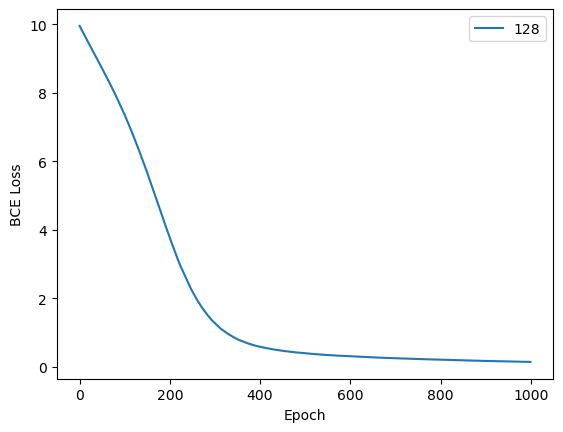

In [15]:
import matplotlib.pyplot as plt

plt.plot(loss_model_128, label="128")

plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.legend()
plt.show()

#### Recommendations with the trained Factorization Model
Write a function that recommends topK items to a user, whose id is given, using the trained model.
Recommendation should be done in a fashion similar to *svd_recommend*: score items based the corresponding embeddings. Do not consider items already seen by the user.

In [16]:
def itMF_recommend(user_id: int, seen_item_ids: list, model=None, topK: int = 10) -> np.ndarray:
    """
    Recommend with the trained model to selected users
    
    user_id - int, id of target user;
    seen_item_ids - list[list[int]], ids of items already seen by the users (to exclude from recommendation);
    model - trained factorization model to use for scoring;
    topK - int, number of recommendations per user to be returned;
    
    returns - 1D np.ndarray, list of ids of recommended items in the order of descending score
                           use -1 as a place holder item index, when it is impossible to recommend topK items;
    """
    recs = None

    model.eval()

    # TODO: YOUR IMPLEMENTATION.

    all_item_ids = torch.arange(model.embedding_item.num_embeddings, dtype=torch.long)
    user_tensor  = torch.tensor([user_id], dtype=torch.long)  # shape: (1,)

    with torch.no_grad():
        logits = model(user_tensor, all_item_ids) 
        scores = logits.squeeze(0)

    scores[seen_item_ids] = float('-inf')

    ranked_items = torch.argsort(scores, descending=True)

    top_k_items = ranked_items[:topK].cpu().numpy()

    if len(top_k_items) < topK:
        top_k_items = np.concatenate([top_k_items, np.full(topK - len(top_k_items), -1)])

    recs = top_k_items

    return recs

In [17]:
user_id = 5
seen_list = np.where(train_data_inter[user_id] != 0)

itMF_recommend(user_id, seen_list, model_128)

array([ 85, 167,  30,   3, 117,  64, 348, 282, 286, 269])

In [18]:
# The end.